In [1]:
import sys 
import os
import cymetric as cym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
    
%matplotlib inline

In [2]:
### weak point....need to have these variables in a file that input + analysis both use ###
add_intro = 12*5
trans_sfr = 12*15

impt_times = [add_intro, trans_sfr]

In [3]:
#db = cym.dbopen('../output/01_full-add_flat-pwr.sqlite')
#db = cym.dbopen('../output/01_full-add_grow-pwr.sqlite')
#db = cym.dbopen('../output/01_ramp-add_flat-pwr.sqlite') # not working, sim fails
#db = cym.dbopen('../output/01_ramp-add_grow-pwr.sqlite') # not working, sim fails
#db = cym.dbopen('../output/23_full-add_flat-pwr.sqlite')
db = cym.dbopen('../output/23_full-add_grow-pwr.sqlite') # not working, bad power curve
ev = cym.Evaluator(db=db, write=False)

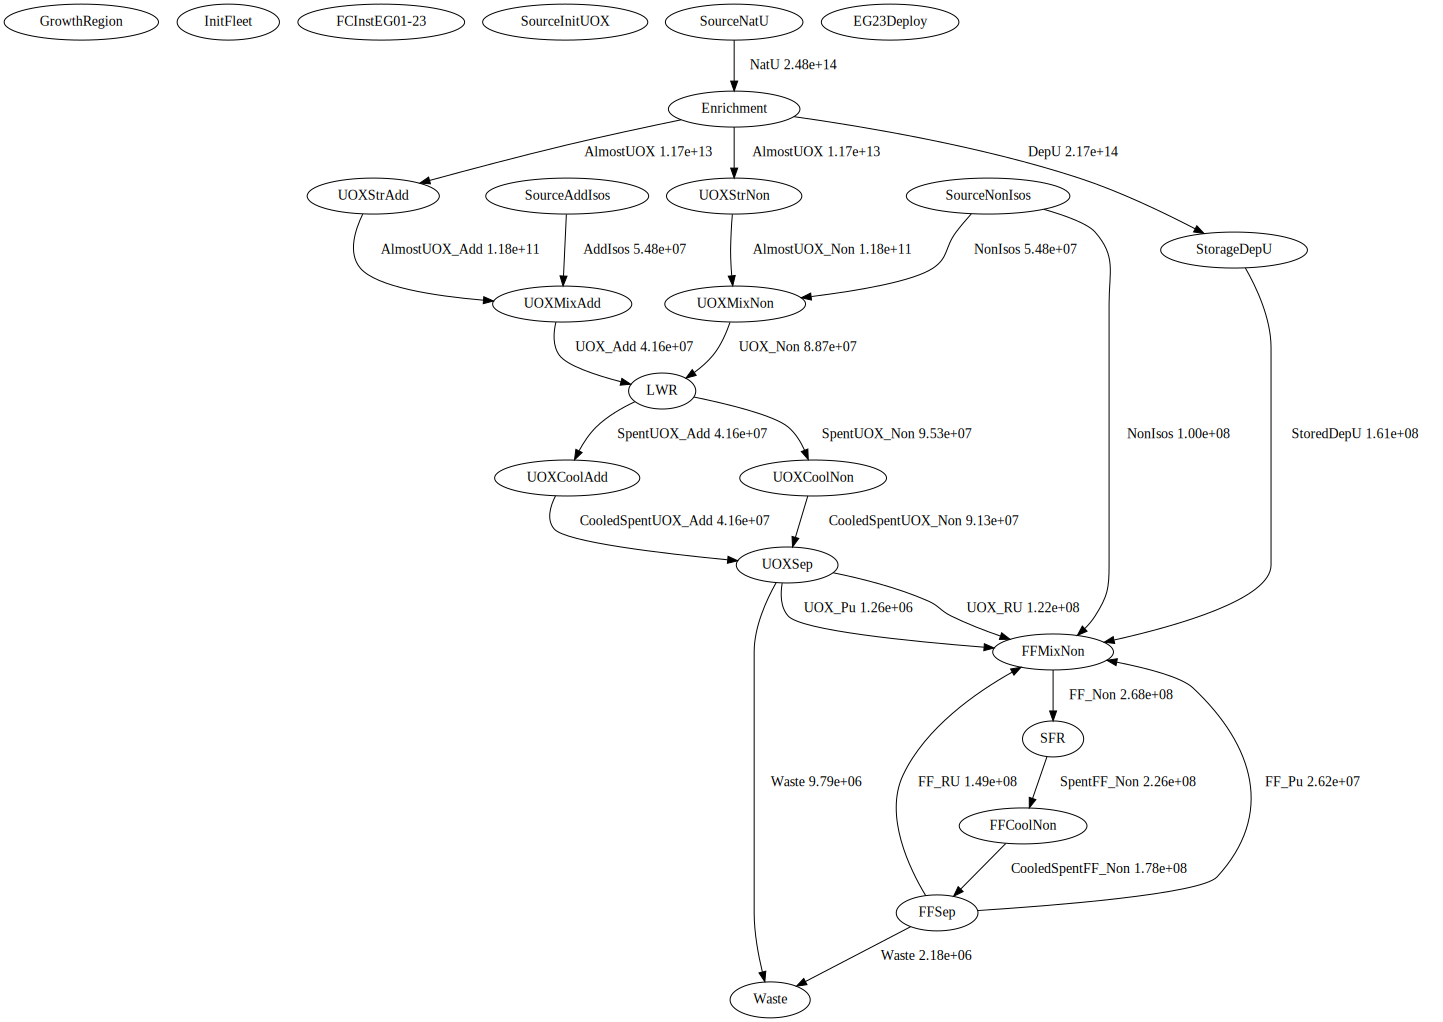

In [4]:
d = cgr.flow_graph(ev, label=['com', 'mass'], start=18)
#d.render('eg23',format='png', view=True)
d

# Time Series Power

In [17]:
def pwr_plt(dfs):
    ax = dfs[0].plot(x='Year', figsize=(9,5), legend=False)

    
    for df in dfs[1:]:
        df.plot(x='Year', figsize=(9,5), legend=False, ax=ax)
    plt.xlabel(r'Year', fontsize=20)
    plt.ylabel(r'Power (GWe)',fontsize=20)
    ax.minorticks_on()
    #ax.set_ylim(-9, 281)
    #ax.set_xlim(0, 100)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.grid()
    plt.show()
    return

/root/.local/lib/python3.6/site-packages/cymetric/timeseries.py:203: UserWarning: no faciity provided
  warnings.warn(wng_msg, UserWarning)


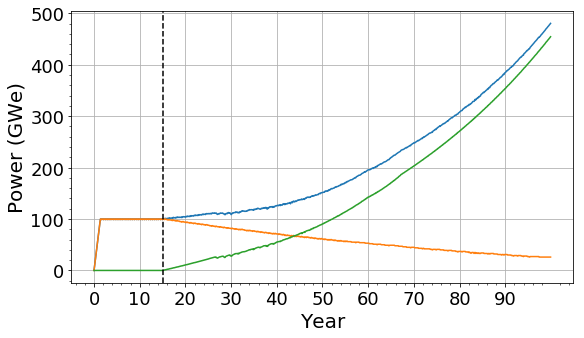

     Time    Value  Year
180   180  99000.0  15.0


In [18]:
df_tspower = tm.get_power(ev, [])
df_tspower1 = tm.get_power(ev, ['LWR'])
df_tspower2 = tm.get_power(ev, ['SFR'])
df_tspower['Year'] = df_tspower['Time'] / 12.
df_tspower1['Year'] = df_tspower1['Time'] / 12.
df_tspower2['Year'] = df_tspower2['Time'] / 12.
# power in GWe
power = df_tspower.groupby(['Year'])['Value'].sum() / 1000.0
power1 = df_tspower1.groupby(['Year'])['Value'].sum() / 1000.0
power2 = df_tspower2.groupby(['Year'])['Value'].sum() / 1000.0
pwr_plt([power, power1, power2])
print(df_tspower[df_tspower['Year'] == 15])

In [ ]:
# BaM EG23 power curve -- for visual comparison

eg23db = cym.dbopen('../../bam_eg_studies/EG23/cyclus.sqlite')
eg23ev = cym.Evaluator(db=eg23db, write=False)
df_tspower = eg23ev.eval('TimeSeriesPower')
df_tspower['Year'] = df_tspower['Time'] / 12.
# power in GWe
power = df_tspower.groupby(['Year'])['Value'].sum() / 1000.0
pwr_plt(power)

# EG01 Plots

In [ ]:
def rxtr_enter_exit_total(evaler):
        
    comm = evaler.eval('BuildSeries')
    decomm = evaler.eval('DecommissionSeries')

    neg = -decomm['Count']
    decomm = decomm.drop('Count',axis=1)
    decomm = pd.concat([decomm, neg],axis=1)
    
    comm = comm.rename(columns={'EnterTime':'Time'})
    decomm = decomm.rename(columns={'ExitTime':'Time'})
    
    comm = comm.pivot('Time','Prototype')['Count'].reset_index()
    decomm = decomm.pivot('Time','Prototype')['Count'].reset_index()
    comm_decomm = pd.merge(comm, decomm, left_on='Time', right_on='Time', how='outer', sort=True, \
                           suffixes=('_enter', '_exit')).fillna(0)
    comm_decomm.Time = comm_decomm.Time.astype(int)
    
    return comm_decomm

In [ ]:
def fuel_quant(evaler, ramp):
    
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    
    uoxnon = transactions.loc[transactions['Commodity'] == 'UOX_Non'][['Time', 'Quantity']]
    uoxadd = transactions.loc[transactions['Commodity'] == 'UOX_Add'][['Time', 'Quantity']]
    if ramp == True:
        uox10p = transactions.loc[transactions['Commodity'] == 'UOX_10pctAdd'][['Time', 'Quantity']]
        uox50p = transactions.loc[transactions['Commodity'] == 'UOX_50pctAdd'][['Time', 'Quantity']]
    
    fuel = evaler.eval('TimeList').rename(columns={'TimeStep':'Time'})
    fuel['UOXnon_refuel'] = uoxnon.groupby(['Time']).sum()['Quantity']
    fuel['UOXadd_refuel'] = uoxadd.groupby(['Time']).sum()['Quantity']
    if ramp == True:
        fuel['UOX10add_refuel'] = uox10p.groupby(['Time']).sum()['Quantity']
        fuel['UOX50add_refuel'] = uox50p.groupby(['Time']).sum()['Quantity']
    fuel.fillna(0, inplace=True)
    if ramp == True:
        fuel['total_refuel'] = fuel['UOXnon_refuel'] + fuel['UOX10add_refuel'] + fuel['UOX50add_refuel'] + fuel['UOXadd_refuel']
    else:
        fuel['total_refuel'] = fuel['UOXnon_refuel'] + fuel['UOXadd_refuel']
    fuel = fuel.loc[fuel['total_refuel'] > 0].reset_index(drop=True)    
    
    return fuel

In [ ]:
def assem_swaps(evaler):
    
    events = evaler.eval('ReactorEvents')
    events = events.loc[(events['Event'] == 'LOAD') | (events['Event'] == 'DISCHARGE')].copy()
    vals = np.asarray(events['Value'].str.split().tolist())[:,0]
    events['Assemblies'] = [int(x) for x in vals]

    assem_swap = events[['Time', 'Event', 'Assemblies']].groupby(['Time', 'Event']).sum().reset_index()
    assem_swap = assem_swap.pivot('Time', 'Event')['Assemblies'].fillna(0).reset_index()
    
    return assem_swap

In [ ]:
cycle_time = 18
intro_50 = add_intro + 3 * cycle_time
intro_100 = intro_50 + 3 * cycle_time

def fuel_pcts(evaler, ramp):
    assem_core = 3
    assem_size = 29565

    rxtrs = rxtr_enter_exit_total(evaler)
    rxtrs['LWR_total'] = rxtrs['LWR_enter'].cumsum() + rxtrs['LWR_exit'].cumsum()
    fuels = fuel_quant(evaler, ramp)
    assem_swap = assem_swaps(evaler)

    f = fuels.merge(rxtrs, on='Time', how='outer', sort=True)
    f = f.merge(assem_swap, on='Time', how='outer', sort=True)
    f['LWR_total'] = f[['LWR_total']].fillna(method='ffill')
    f.drop(0, inplace=True)
    f.fillna(0, inplace=True)
    f.reset_index(drop=True, inplace=True)

    f['LWR_total_assem'] = assem_core * f['LWR_total']
    f['UOXnon_refuel_assem'] = f['UOXnon_refuel'] / assem_size
    f['UOXadd_refuel_assem'] = f['UOXadd_refuel'] / assem_size
    if ramp == True:
        f['UOX10add_refuel_assem'] = f['UOX10add_refuel'] / assem_size
        f['UOX50add_refuel_assem'] = f['UOX50add_refuel'] / assem_size

# calculating percent of additive v nonadditive fuel
# first stab, very poorly done. 
# 
# this isn't actually measuring anything from the DB, it is taking user defined times and 
# additive replacement schemes and applying it to the discharging and loading of fuel in LWRs

#!!!!!!!******
# presumes that upon introduction, only additive is replacing non-additive
# also (maybe obvious) presumes only non is replacing non in the beginning...
# this allows non_pct and add_pct to stay at 100 & 0, respectively, until additive is introduced
# have to assume discharge is always nonadditive until that runs out.....
#******!!!!!

    def non_step_down(frac, non, add, f):
        f.loc[i, 'UOXnon_tally'] = non - row['DISCHARGE'] + (1 - frac) * row['LOAD']
        non = f.loc[i, 'UOXnon_tally']
        f.loc[i, 'UOXadd_tally'] = add + frac * row['LOAD']
        add = f.loc[i, 'UOXadd_tally']
        return non, add, f

    f['UOXnon_tally'] = 0
    f['UOXadd_tally'] = 0
    non_uox_track = 0
    add_uox_track = 0
        
    if ramp == False:
        for i, row in f.iterrows():
            if row['Time'] < add_intro:
                f.loc[i, 'UOXnon_tally'] = row['LWR_total_assem'] # since the math is already done in this col
                non_uox_track = f.loc[i, 'UOXnon_tally']
            elif row['Time'] >= add_intro:
                if non_uox_track > 0:
                    if non_uox_track - row['DISCHARGE'] < 0: # very last row of stepping down non_tally usually results in negatives
                        f.loc[i, 'UOXnon_tally'] = 0
                        f.loc[i, 'UOXadd_tally'] = add_uox_track + non_uox_track
                        non_uox_track = 0
                        add_uox_track = f.loc[i, 'UOXadd_tally']
                    else:
                        non_uox_track, add_uox_track, f = non_step_down(1, non_uox_track, add_uox_track, f)
                else:
                    f.loc[i, 'UOXadd_tally'] = row['LWR_total_assem'] # since the math is already done in this col
    else: 
        # naughty naughty copying first and last from above...
        for i, row in f.iterrows():
            if row['Time'] < add_intro:
                f.loc[i, 'UOXnon_tally'] = row['LWR_total_assem']
                non_uox_track = f.loc[i, 'UOXnon_tally']
            elif row['Time'] >= add_intro and row['Time'] < intro_50:
                non_uox_track, add_uox_track, f = non_step_down(0.1, non_uox_track, add_uox_track, f)
            elif row['Time'] >= intro_50 and row['Time'] < intro_100:
                non_uox_track, add_uox_track, f = non_step_down(0.5, non_uox_track, add_uox_track, f)
            elif row['Time'] >= intro_100:
                if non_uox_track > 0:
                    if non_uox_track - row['DISCHARGE'] < 0:
                        f.loc[i, 'UOXnon_tally'] = 0
                        f.loc[i, 'UOXadd_tally'] = row['LWR_total_assem'] # b/c discharge could be greater than load here
                        non_uox_track = 0
                        add_uox_track = f.loc[i, 'UOXadd_tally']   
                    else:
                        non_uox_track, add_uox_track, f = non_step_down(1, non_uox_track, add_uox_track, f)
                else:
                    f.loc[i, 'UOXadd_tally'] = row['LWR_total_assem']
        
    f['UOXtot_check'] = f['UOXnon_tally'] + f['UOXadd_tally']
    f['UOXnon_pct'] = 100 * f['UOXnon_tally'] / f['LWR_total_assem']
    f['UOXadd_pct'] = 100 * f['UOXadd_tally'] / f['LWR_total_assem']

    # teeny tests
    check_pct = f['UOXnon_pct'] + f['UOXadd_pct'] - 100
    assert check_pct.sum() < 1e-10
    check_assem = f['UOXtot_check'] - f['LWR_total_assem']
    assert check_assem.sum() < 1e-10
    return f

In [ ]:
f = fuel_pcts(ev, True)
filt = ['Time', 'DISCHARGE', 'LOAD', 'LWR_total_assem', 'UOXnon_tally', 'UOXadd_tally', 'UOXnon_pct', 'UOXadd_pct']
#f[filt].loc[f['Time'] > 181].head(15)

In [ ]:
def plot_fuel_pcts(evaler, ramp):
    
    f = fuel_pcts(evaler, ramp)
    
    pcts = f[['Time', 'UOXnon_pct', 'UOXadd_pct']]

    ax = pcts.plot(x='Time', figsize=(11,7), legend=False, linewidth=3)
    plt.xlabel('Time (months)',fontsize=20)
    plt.ylabel('Percent (%)',fontsize=20)
    plt.title('Percent Fuel without/with Additive', fontsize=20)
        
    legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
    legend.get_texts()[0].set_text('Without Additive')
    legend.get_texts()[1].set_text('With Additive')
    
    if ramp == True:
        for t in [add_intro, intro_50, intro_100]:
            plt.axvline(x=t, color='k', linestyle='--', linewidth=1)
    else:
        plt.axvline(x=add_intro, color='k', linestyle='--')        
        
    ax.minorticks_on()
    ax.tick_params(labelsize=16)
    
    ax.set_xlim(0, 400)
        
    plt.show()

In [ ]:
plot_fuel_pcts(ev, True)

In [ ]:
plot_fuel_pcts(ev, False)

# EG01-->23 Plots

## Fuel types

In [ ]:
def plot_fuel(evaler, flow_cumul):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions['Year'] = transactions['TimeCreated'] / 12.
    non_uox = transactions.loc[transactions['Commodity'] == 'UOX_Non']
    add_uox = transactions.loc[transactions['Commodity'] == 'UOX_Add']
    ff = transactions.loc[transactions['Commodity'] == 'FF_Non']
    
    if flow_cumul == 'cumul':
        transactions['UOXnon_total'] = non_uox['Quantity'].cumsum()
        transactions['UOXadd_total'] = add_uox['Quantity'].cumsum()
        transactions['FastFuel_total'] = ff['Quantity'].cumsum()
        transactions.fillna(method='ffill', inplace=True)
        transactions['total_fuel'] = (transactions['UOXnon_total'] + transactions['UOXadd_total'] + 
                                      transactions['FastFuel_total'])

        # Plotting cumulative fuel sent to reactors at each time step
        l = ['Year', 'UOXnon_total', 'UOXadd_total', 'FastFuel_total', 'total_fuel']
        ax = transactions[l].plot(x='Year', figsize=(11,7), legend=False)
        plt.xlabel('Year',fontsize=20)
        plt.ylabel('Mass of fuel fabricated (kg)',fontsize=20)

        legend = plt.legend(fontsize=14, title='Fuel Type', title_fontsize=14)
        legend.get_texts()[0].set_text('UOX without Additive')
        legend.get_texts()[1].set_text('UOX with Additive')
        legend.get_texts()[2].set_text('FastFuel (no Additive)')
        legend.get_texts()[3].set_text('Total')
        
        lines = ax.get_children()
        lines[3].set_zorder(0)
    
        ax.minorticks_on()
        ax.set_xticks(np.arange(0, 100, 10))
        ax.tick_params(labelsize=18)
        
        for t in impt_times:
            plt.axvline(x=t/12., color='k', linestyle='--')

        #ax.set_xlim(0, 40)
        #ax.set_ylim(-4.9e6, 1e8)
        plt.show()
    elif flow_cumul == 'flow':
        flow = pd.DataFrame({'UOXnon_flow' : non_uox.groupby(['Year']).sum()['Quantity'],
                             'UOXadd_flow' : add_uox.groupby(['Year']).sum()['Quantity'],
                             'FastFuel_flow'  : ff.groupby(['Year']).sum()['Quantity']
                            }).reset_index()
        
        # Plotting fuel flow to reactors at each time step
        ax = flow.plot(x='Year', figsize=(11,7), legend=False)
        plt.xlabel('Year',fontsize=20)
        plt.ylabel('Mass of fuel flow to reactors (kg)',fontsize=20)
        
        legend = plt.legend(fontsize=14, title='Fuel Type')#, title_fontsize=14)
        legend.get_texts()[0].set_text('UOX without Additive')
        legend.get_texts()[1].set_text('UOX with Additive')
        legend.get_texts()[2].set_text('FastFuel (no Additive)')
        
        ax.minorticks_on()
        ax.set_xticks(np.arange(0, 100, 10))
        ax.tick_params(labelsize=18)
        
        for t in impt_times:
            plt.axvline(x=t/12., color='k', linestyle='--')
        
        plt.show()
    else: 
        print('Only plots mass flow or cumulative mass of fuel!')
    return

In [ ]:
plot_fuel(ev, 'flow')

In [ ]:
plot_fuel(ev, 'cumul')

## Reactor types being deployed

In [ ]:
def plot_rxtr_enter_exit_total(evaler):
        
    comm_decomm = rxtr_enter_exit_total(evaler)
    # get cumulative sums of _enter and_exit columns for reactors
    for rx in ['LWR', 'SFR']:
        comm_decomm[str(rx) + '_total'] = comm_decomm[str(rx) + '_enter'].cumsum() + \
                                          comm_decomm[str(rx) + '_exit'].cumsum()
    
    comm_decomm['Year'] = comm_decomm['Time'] / 12.
    ax = comm_decomm[['Year', 'LWR_total', 'SFR_total']].plot(x='Year', figsize=(9, 5), \
                                                              legend=False)
    
    legend = plt.legend(fontsize=14, title='Reactor Type')#, title_fontsize=14)
    legend.get_texts()[0].set_text('LWR')
    legend.get_texts()[1].set_text('SFR')
    legend.set_title('Prototype')
    plt.xlabel(r'Year', fontsize=18)
    plt.ylabel(r'Count',fontsize=18)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.show()
    
    return 

In [ ]:
plot_rxtr_enter_exit_total(ev)

# Pre-fuel Mass Flows

In [ ]:
def plot_flow(evaler, add_or_uox):
    transactions = evaler.eval('TransactionQuantity').sort_values(by='TimeCreated')
    transactions = transactions.rename(columns={'TimeCreated':'Time'})
    if add_or_uox == 'add':
        l0 = 'NonIsos'
        l1 = 'AddIsos'
        title = 'Mixer Additives'
    elif add_or_uox == 'uox':
        l0 = 'AlmostUOX_Non'
        l1 = 'AlmostUOX_Add'
        title = 'Mixer UOX'
    else:
        l0 = 'NatU'
        l1 = 'AlmostUOX'
        title = 'Enrichment Flow'
    
    non = transactions.loc[transactions['Commodity'] == l0]
    add = transactions.loc[transactions['Commodity'] == l1]
    flow = pd.DataFrame({'non_flow' : non.groupby(['Time']).sum()['Quantity'],
                         'add_flow' : add.groupby(['Time']).sum()['Quantity']}).reset_index()
    
    # Plotting mass flows at each time step
    ax = flow.plot(x='Time', figsize=(11,7), legend=False)
    plt.xlabel('Time (months)',fontsize=20)
    plt.ylabel('Mass of material flow (kg)',fontsize=20)
    plt.title(title, fontsize=20)
        
    legend = plt.legend(fontsize=14, title='UOX Flow Type', title_fontsize=14)
    legend.get_texts()[0].set_text(l0)
    legend.get_texts()[1].set_text(l1)
        
    ax.minorticks_on()
    ax.tick_params(labelsize=16)
    ax.set_xlim(-10, 1200)
    if add_or_uox == 'add':
        ax.set_ylim(-1e3, 5.1e5)

        
    plt.show()


In [ ]:
# Additive, NonAdditive
plot_flow(ev, 'add')

In [ ]:
#AlmostUOX
plot_flow(ev, 'uox')

In [ ]:
# NU is without A (2.1e11) and AlmostUOX is with A (2e10)
plot_flow(ev, 'enr')